In [112]:
!pip install us

In [113]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import us
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder


In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
file_name = 'drive/MyDrive/realtor-data.csv'
data = pd.read_csv(file_name)

In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB


In [117]:
for feature in data.columns:
    print(feature, data[feature].isna().value_counts())

brokered_by brokered_by
False    2221849
True        4533
Name: count, dtype: int64
status status
False    2226382
Name: count, dtype: int64
price price
False    2224841
True        1541
Name: count, dtype: int64
bed bed
False    1745065
True      481317
Name: count, dtype: int64
bath bath
False    1714611
True      511771
Name: count, dtype: int64
acre_lot acre_lot
False    1900793
True      325589
Name: count, dtype: int64
street street
False    2215516
True       10866
Name: count, dtype: int64
city city
False    2224975
True        1407
Name: count, dtype: int64
state state
False    2226374
True           8
Name: count, dtype: int64
zip_code zip_code
False    2226083
True         299
Name: count, dtype: int64
house_size house_size
False    1657898
True      568484
Name: count, dtype: int64
prev_sold_date prev_sold_date
False    1492085
True      734297
Name: count, dtype: int64


There is a lot of missing value for house_size, prev_sold_date, bed, bath, acre_lot. We will consider imputing strategy for these features.

The other features have very small proportion of missing values. We can consider dropping strategy for these features.

In [118]:
data.dropna(subset=["brokered_by", "price", "street", "city", "state", "zip_code"], inplace=True)

In [119]:
data.shape

(2207981, 12)

In [120]:
for feature in data.columns:
    print(feature, data[feature].nunique())

brokered_by 109654
status 3
price 101530
bed 99
bath 86
acre_lot 15841
street 1995163
city 19675
state 55
zip_code 30251
house_size 12018
prev_sold_date 14937


Since there is a lot of missing values, we will have to impute data

Since there is so many unique values for bed and bath. We suspect that there must be some issues with it (mistyped, wrong format)

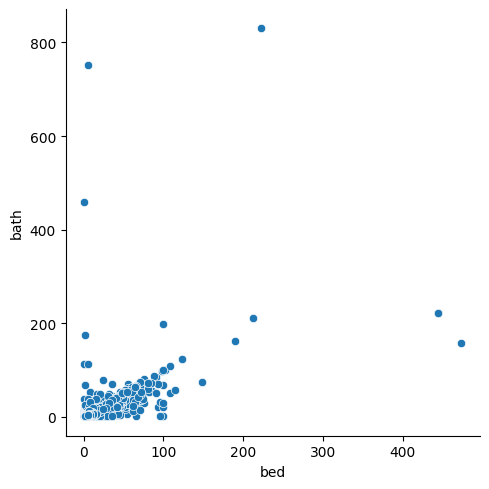

In [121]:
sns.relplot(
    data,
    x="bed",
    y="bath",
    # title="# of bed and # of bath correlation"
)

# Replace with px.scatter before submit

Based on the graph, we can see that there are a lot of unrealistic values for both beds and baths. There are even house with 1 bed and 460 bathrooms. Moreover, this dataset is collected from a real estate website. We can safely say that office and buildings may not be included in this dataset. Hence, we assume that a house generally, only has maximum of 9 beds and 9 baths.

Strategy: Format values for bed and bath to only take the first digit of the value (e.g: 333 baths = 3 baths). Exclude 0 values for both baths and beds. Moreover, a house can have more bathrooms than bedrooms. However, we assume the relationship that the difference between bed no. and bath no. must be <= (bed no. / 2).

In [122]:
# Cleaning bed and bath mistype.
def clean_bed_and_bath(data):
    def clean_data(x):
        while x >= 10:
            x = x // 10
        return x

    data["bed"] = data["bed"].apply(clean_data)
    data["bath"] = data["bath"].apply(clean_data)
    data = data[(np.abs(data["bed"] - data["bath"]) <= (data["bed"] / 2))]
    return data


bed_bath_cleaner = FunctionTransformer(clean_bed_and_bath)

bed_bath_cleaner.fit_transform(data)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
5,103378.0,for_sale,179000.0,4.0,3.0,0.46,1850806.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2226377,23009.0,sold,359900.0,4.0,2.0,0.33,353094.0,Richland,Washington,99354.0,3600.0,2022-03-25
2226378,18208.0,sold,350000.0,3.0,2.0,0.10,1062149.0,Richland,Washington,99354.0,1616.0,2022-03-25
2226379,76856.0,sold,440000.0,6.0,3.0,0.50,405677.0,Richland,Washington,99354.0,3200.0,2022-03-24
2226380,53618.0,sold,179900.0,2.0,1.0,0.09,761379.0,Richland,Washington,99354.0,933.0,2022-03-24


In [123]:
data[["bed", "bath"]].isna().value_counts()

bed    bath 
False  False    1695130
True   True      464920
False  True       38646
True   False       9285
Name: count, dtype: int64

This is the dataset that fits our assumptions perfectly. However, it excluded all the nan values of beds and baths. We will use this dataset to train linear regression model to impute bed and bath for the original dataset.

ZIP code cannot tell the exact state so we want to transform state to abbr for plotting with folium. Then create an fips column for training the model. We cannot find the geojson file that contain location of state fips to use with folium. State abbr will be drop later.

In [124]:
def state_transformer(data):
  map = us.states.mapping('abbr', 'fips')
  def name_to_abbr(state_name):
    state = us.states.lookup(state_name)
    if state:
        return state.abbr
    else:
        return "Unknown"

  def abbr_to_fips(x):

    if x in map:
      return map[x]
    return 0
  data["state"] = data["state"].apply(name_to_abbr)
  data["fips"] = data["state"].apply(abbr_to_fips)
  return data


state_convert = FunctionTransformer(state_transformer)
state_convert.fit_transform(data)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,fips
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,PR,601.0,920.0,NaN,72
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,PR,601.0,1527.0,NaN,72
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,PR,795.0,748.0,NaN,72
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,PR,731.0,1800.0,NaN,72
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,PR,680.0,NaN,NaN,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226377,23009.0,sold,359900.0,4.0,2.0,0.33,353094.0,Richland,WA,99354.0,3600.0,2022-03-25,53
2226378,18208.0,sold,350000.0,3.0,2.0,0.10,1062149.0,Richland,WA,99354.0,1616.0,2022-03-25,53
2226379,76856.0,sold,440000.0,6.0,3.0,0.50,405677.0,Richland,WA,99354.0,3200.0,2022-03-24,53
2226380,53618.0,sold,179900.0,2.0,1.0,0.09,761379.0,Richland,WA,99354.0,933.0,2022-03-24,53


In [125]:
import requests

state_mean = data.groupby("state")["price"].mean().reset_index()
us_states = requests.get(
    "https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json"
).json()

state_mean = state_mean[state_mean["state"] != "Unknown"]
m = folium.Map([43, -100], zoom_start=4)

folium.Choropleth(
    geo_data=us_states,
    data=state_mean,
    columns=["state", "price"],
    key_on="feature.id",
).add_to(m)
m

The distribution of price by state is big. There is huge difference between the average price by state.

Next, we will encode listing status data

In [126]:
data.status.value_counts()

status
for_sale          1377825
sold               806361
ready_to_build      23795
Name: count, dtype: int64

Since there is only 3 types of status, we can use one-hot encoding for this one.

In [127]:
# Use get dummies for
encoder = OneHotEncoder(sparse=False)
status_encoded = encoder.fit_transform(data[['status']])

status_df = pd.DataFrame(status_encoded, columns=encoder.get_feature_names_out(['status']))
transformed_data = pd.concat([data.drop(columns=['status']), status_df], axis=1)
data = transformed_data.dropna(subset="state")

# Use OneHotEncoder in pipeline
data

,brokered_by,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,fips,status_for_sale,status_ready_to_build,status_sold
0,103378.0,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,PR,601.0,920.0,NaN,72,1.0,0.0,0.0
1,52707.0,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,PR,601.0,1527.0,NaN,72,1.0,0.0,0.0
2,103379.0,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,PR,795.0,748.0,NaN,72,1.0,0.0,0.0
3,31239.0,145000.0,4.0,2.0,0.10,1947675.0,Ponce,PR,731.0,1800.0,NaN,72,1.0,0.0,0.0
4,34632.0,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,PR,680.0,NaN,NaN,72,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226377,23009.0,359900.0,4.0,2.0,0.33,353094.0,Richland,WA,99354.0,3600.0,2022-03-25,53,NaN,NaN,NaN
2226378,18208.0,350000.0,3.0,2.0,0.10,1062149.0,Richland,WA,99354.0,1616.0,2022-03-25,53,NaN,NaN,NaN
2226379,76856.0,440000.0,6.0,3.0,0.50,405677.0,Richland,WA,99354.0,3200.0,2022-03-24,53,NaN,NaN,NaN
2226380,53618.0,179900.0,2.0,1.0,0.09,761379.0,Richland,WA,99354.0,933.0,2022-03-24,53,NaN,NaN,NaN


<Axes: >

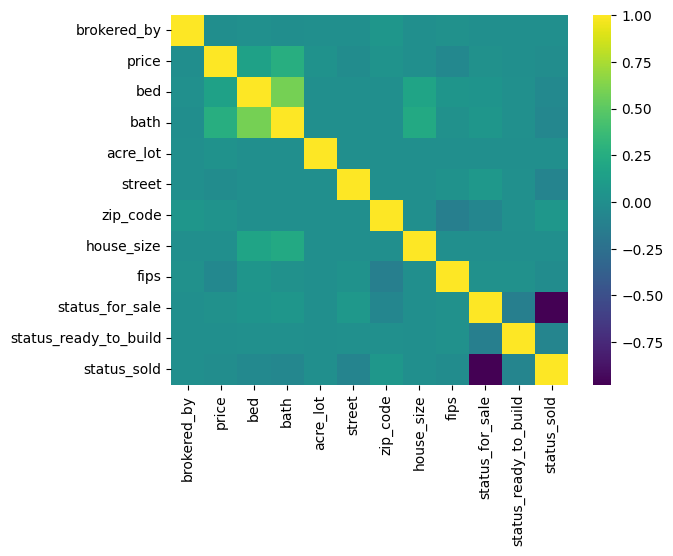

In [128]:
all_numeric = transformed_data.drop(columns=["state", "city", 'prev_sold_date'])
# all_numeric['prev_sold_date'] = pd.to_datetime(all_numeric["prev_sold_date"])
correlation = all_numeric.corr()
sns.heatmap(
    data=correlation,
    cmap='viridis'
)